In [1]:
import pandas as pd
import numpy as np

import os

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv1D, MaxPooling1D
from tensorflow.keras.layers import LSTM, TimeDistributed, ConvLSTM2D

from sklearn.model_selection import train_test_split

In [2]:
data_path = os.getcwd() + "/dataset/total_concentrated.csv"
#features = ["A_F", "A_V", "A_L", "L_F", "L_T", "L_L", "T_F", "T_V", "T_L"]

dataset = pd.read_csv(data_path)
time = list(dataset['time'])
dataframe = dataset[["A_F", "A_V", "A_L", "L_F", "L_V", "L_L", "T_F", "T_V", "T_L"]].values
dataset = dataset[["A_F", "A_V", "A_L", "L_F", "L_V", "L_L", "T_F", "T_V", "T_L", "Action"]].values

window_length = int(4*64)
total_windows = int((len(dataset))/window_length)

In [3]:
dataframe = (dataframe-dataframe.mean())/dataframe.std()

In [4]:
def evaluate_model(trainX, trainy, testX, testy):
    verbose, epochs, batch_size = 0, 50, 64
    n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]

    n_steps, n_length = 2, 128
    trainX = trainX.reshape((trainX.shape[0], n_steps, n_length, n_features))
    testX = testX.reshape((testX.shape[0], n_steps, n_length, n_features))

    model = Sequential()
    model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'), 
                              input_shape=(None, n_length, n_features)))
    model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu')))
    model.add(TimeDistributed(Dropout(0.5)))
    model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
    model.add(TimeDistributed(Flatten()))
    model.add(LSTM(100))
    model.add(Dropout(0.5))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(n_outputs, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose)

    _, accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
    return accuracy

In [5]:
'''
X = np.empty((total_windows, window_length, 9))
y = np.empty((total_windows, 1))
j = 0

window_count = 0
for items in range(total_windows):
    for i in range(window_length):
        if i == 0:
            y[j] = dataset[int(window_count*window_length), 9]
            j = j + 1
        for data in range(9):
            X[items, i, data] = dataset[int(window_count*window_length)+i, data]
    window_count = window_count+1

del window_count, i, j, items, data
'''

'\nX = np.empty((total_windows, window_length, 9))\ny = np.empty((total_windows, 1))\nj = 0\n\nwindow_count = 0\nfor items in range(total_windows):\n    for i in range(window_length):\n        if i == 0:\n            y[j] = dataset[int(window_count*window_length), 9]\n            j = j + 1\n        for data in range(9):\n            X[items, i, data] = dataset[int(window_count*window_length)+i, data]\n    window_count = window_count+1\n\ndel window_count, i, j, items, data\n'

In [6]:
indices = time
groups = []
group_count = 0
temp = []
lenOfGroup = []
length_count = 0

for i in range(len(indices)):
    if i == (len(indices) - 1):
        temp.append(indices[i])
        length_count = length_count + 1

        groups.append(temp)
        lenOfGroup.append(length_count)
        length_count = 0
        temp = []
        break
    temp.append(indices[i])
    length_count = length_count + 1
    if (indices[i+1] - 20 > indices[i]):
        group_count = group_count + 1

        lenOfGroup.append(length_count)
        length_count = 0

        groups.append(temp)
        temp = []

del temp, indices, group_count, length_count, i

In [7]:
countOfUndivisible = 0
total_windows_with_overlap = 0

start_index = 0

stop_Indexs = []
stop_Index = -window_length


for lengths in lenOfGroup:
    stop_Index = stop_Index + lengths
    stop_Indexs.append(stop_Index)
    total_windows_with_overlap = total_windows_with_overlap + int(lengths/window_length*2 -1)
    
    if lengths % (window_length) != 0:
        countOfUndivisible = countOfUndivisible + 1
        print(lengths)

print(countOfUndivisible)
del countOfUndivisible, lengths

0


In [8]:
X = np.empty((total_windows, window_length*9))
y = np.empty((total_windows, 1))
j = 0

window_count = 0
for window in range(total_windows):
    for i in range(window_length):
        if i == 0:
            y[j] = dataset[window_count*window_length, 9]
            j = j + 1
        for data in range(9):
            X[window, i*9 + data] = dataframe[window_count*window_length + i, data]
    window_count = window_count + 1

del window_count, i, j, window, data

In [9]:
from sklearn.model_selection import StratifiedKFold

In [10]:
skf = StratifiedKFold(n_splits=3, shuffle = True, random_state=42)
skf.get_n_splits(X, y)
print(skf)

StratifiedKFold(n_splits=3, random_state=42, shuffle=True)


In [11]:
def to_3Darray(array):
    arr_3d = np.empty((len(array), window_length, 9))


    arr_3d = np.reshape(array, (len(array), window_length, 9))
    return arr_3d

In [12]:
def run_experiment(trainX, trainy, testX, testy, repeats=10):

    scores = list()
    for r in range(repeats):
        score = evaluate_model(trainX, trainy, testX, testy)
        score = score * 100.0
        print('>#%d: %.3f' % (r+1, score))
        scores.append(score)
    
    m, s = np.mean(scores), np.std(scores)
    print('Accuracy: %.3f%% (+/-%.3f)' % (m, s))
    return m

In [13]:
import matplotlib.pyplot as plt

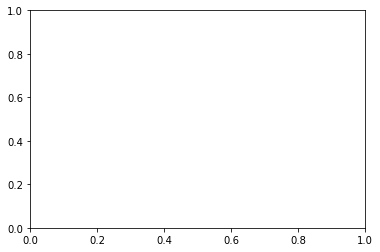

In [14]:
scores = list()
ax = plt.subplots()

In [15]:
scores = []

In [16]:
from sklearn.model_selection import (
    TimeSeriesSplit,
    KFold,
    ShuffleSplit,
    StratifiedKFold,
    GroupShuffleSplit,
    GroupKFold,
    StratifiedShuffleSplit,
    StratifiedGroupKFold,
)
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

np.random.seed(1338)
cmap_data = plt.cm.Paired
cmap_cv = plt.cm.coolwarm
n_splits = 3

In [17]:
unique, counts = np.unique(y, return_counts=True)
for i in range(3):
    print ("[{}, {}]".format(int(unique[i]), counts[i]))

[0, 2469]
[1, 316]
[2, 230]


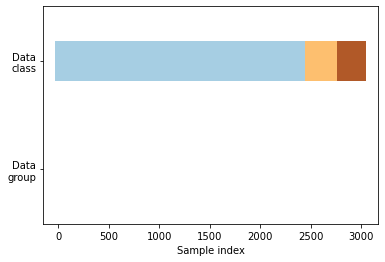

In [18]:
# Generate the class/group data
n_points = total_windows
# X = np.random.randn(100, 10)

y_stack = np.hstack(y)

groups = np.empty((total_windows))
k=0
# Evenly spaced groups repeated once
for i in range(10):
    for j in range(int(total_windows/10)):
        groups[int(i*total_windows/10) + j] = k
    k = k + 1


def visualize_groups(classes, groups, name):
    # Visualize dataset groups
    fig, ax = plt.subplots()
    '''ax.scatter(
        range(len(groups)),
        [0.5] * len(groups),
        c=groups,
        marker="_",
        lw=50,
        cmap=cmap_data,
    )'''
    ax.scatter(
        range(total_windows),
        [3.5] * total_windows,
        c=classes,
        marker="_",
        lw=40,
        cmap=cmap_data,
    )
    ax.set(
        ylim=[-1, 5],
        yticks=[0.5, 3.5],
        yticklabels=["Data\ngroup", "Data\nclass"],
        xlabel="Sample index",
    )


visualize_groups(y_stack, groups, "no groups")

In [19]:
def plot_cv_indices(cv, X, y, group, ax, n_splits, lw=10):
    """Create a sample plot for indices of a cross-validation object."""

    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y, groups=group)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter(
            range(len(indices)),
            [ii + 0.5] * len(indices),
            c=indices,
            marker="_",
            lw=lw,
            cmap=cmap_cv,
            vmin=-0.2,
            vmax=1.2,
        )

    # Plot the data classes and groups at the end
    ax.scatter(
        range(len(X)), [ii + 1.5] * len(X), c=y, marker="_", lw=lw, cmap=cmap_data
    )

    ax.scatter(
        range(len(X)), [ii + 2.5] * len(X), c=group, marker="_", lw=lw, cmap=cmap_data
    )

    # Formatting
    yticklabels = list(range(n_splits)) + ["class", "group"]
    ax.set(
        yticks=np.arange(n_splits + 2) + 0.5,
        yticklabels=yticklabels,
        xlabel="Sample index",
        ylabel="CV iteration",
        ylim=[n_splits + 2.2, -0.2],
        xlim=[0, len(X)],
    )
    ax.set_title("{}".format(type(cv).__name__), fontsize=15)
    return ax

In [20]:
for i, (train_index, val_index) in enumerate(skf.split(X, y)):
    print("==> Fold #%d" % i)
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    X_train = to_3Darray(X_train)
    y_train = to_categorical(y_train)

    X_val = to_3Darray(X_val)
    y_val = to_categorical(y_val)

    
    

    score=run_experiment(X_train, y_train, X_val, y_val, repeats=1)
    scores.append(score)
'''    score = evaluate_model(X_train, y_train, X_val, y_val)
    score = score * 100.0
    print(score)
    scores.append(score)'''

    

==> Fold #0
>#1: 86.269
Accuracy: 86.269% (+/-0.000)
==> Fold #1
>#1: 85.075
Accuracy: 85.075% (+/-0.000)
==> Fold #2
>#1: 86.468
Accuracy: 86.468% (+/-0.000)


'    score = evaluate_model(X_train, y_train, X_val, y_val)\n    score = score * 100.0\n    print(score)\n    scores.append(score)'

In [21]:
m, s = np.mean(scores), np.std(scores)
print('Accuracy: %.3f%% (+/-%.3f)' % (m, s))

Accuracy: 85.937% (+/-0.615)


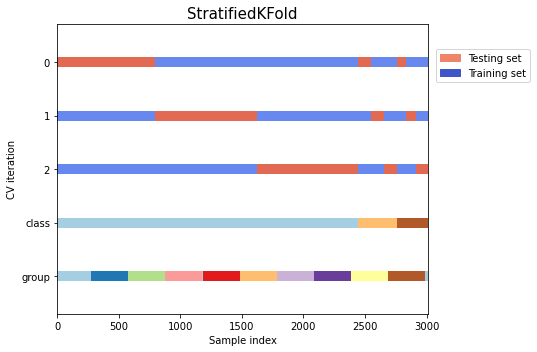

In [22]:
# uneven_groups = np.sort(np.random.randint(0, 3, n_points))
fig, ax = plt.subplots(figsize=(6, 5))
cv = StratifiedKFold(n_splits)
plot_cv_indices(cv, X, y, groups, ax, n_splits)
ax.legend(
    [Patch(color=cmap_cv(0.8)), Patch(color=cmap_cv(0.02))],
    ["Testing set", "Training set"],
    loc=(1.02, 0.8),
)
plt.tight_layout()
fig.subplots_adjust(right=1)